In [1]:
!pip install numpy==1.26.4 pandas==2.2.2 transformers datasets scikit-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
import torch
from torch.utils.data import DataLoader
import numpy as np

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/final_dataset.csv')

In [5]:
# Combine 'header' and 'article' into a single text column
# Handle potential NaN values by converting them to empty strings
df['text'] = df['header'].fillna('') + " " + df['article'].fillna('')

# Rename 'label' column to 'labels' as Hugging Face Trainer expects this
df = df.rename(columns={'label': 'labels'})

# Select only the 'text' and 'labels' columns
df = df[['text', 'labels']]

# Display some info
print(f"DataFrame shape: {df.shape}")
print(df.head())
print(df['labels'].value_counts())

DataFrame shape: (45869, 2)
                                                text  labels
0  Corona-Krise soll ausgenutzt werden, um Mensch...       1
1  Vermerke für »Mutations«-Impfungen bereits vor...       1
2  Merkel droht mit totaler Sperrung: Machtergrei...       1
3  Aber nicht genügend Testmöglichkeiten vorhande...       1
4  AfD-Mitbegründer siegt vor Bundesverfassungsge...       1
labels
0    28056
1    17813
Name: count, dtype: int64


In [6]:
# Split the data into training, validation, and test sets
# It's good practice to have a test set for final evaluation
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['labels'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['labels']) # 0.5 of 0.2 = 0.1 of total

print(f"Train set shape: {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")
print(f"Test set shape: {test_df.shape}")

# Convert Pandas DataFrames to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Create a DatasetDict
raw_datasets = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

print("\nRaw datasets structure:")
print(raw_datasets)

Train set shape: (36695, 2)
Validation set shape: (4587, 2)
Test set shape: (4587, 2)

Raw datasets structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 36695
    })
    validation: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 4587
    })
    test: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 4587
    })
})


In [7]:
MODEL_CHECKPOINT = "FacebookAI/xlm-roberta-large-finetuned-conll03-german"
NUM_LABELS = 2 # 0 for real, 1 for fake

tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=NUM_LABELS)

# Set up label mappings for better readability during evaluation (optional)
# This depends on how your labels are mapped in the dataset (0 and 1)
model.config.id2label = {0: "REAL", 1: "FAKE"}
model.config.label2id = {"REAL": 0, "FAKE": 1}

print("\nTokenizer and Model loaded.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/886 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-large-finetuned-conll03-german and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Tokenizer and Model loaded.


In [18]:
def tokenize_function(examples):
    # Ensure 'text' column exists and is used for tokenization
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512) # Adjust max_length if needed

# Apply tokenization to all splits
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

# Remove the original 'text' column as it's no longer needed after tokenization
# And remove '__index_level_0__' which is added by from_pandas
tokenized_datasets = tokenized_datasets.remove_columns(["text", "__index_level_0__"])

# Rename 'labels' to 'label' if your original df had 'labels' and the model expects 'label'
# (No, for SequenceClassification, 'labels' is correct, but good to be aware of this common confusion)
# No change needed here, as we already renamed 'label' to 'labels' earlier and the Trainer expects 'labels'.

# Set the format to PyTorch tensors
tokenized_datasets.set_format("torch")

print("\nTokenized datasets structure:")
print(tokenized_datasets)

# A DataCollator pads the inputs to the maximum length of the batch
# This is usually preferred over padding all inputs to max_length of the model
# because it saves memory and speeds up training.
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/36695 [00:00<?, ? examples/s]

Map:   0%|          | 0/4587 [00:00<?, ? examples/s]

Map:   0%|          | 0/4587 [00:00<?, ? examples/s]


Tokenized datasets structure:
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 36695
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 4587
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 4587
    })
})


In [19]:
OUTPUT_DIR = "/content/drive/MyDrive/xlm-roberta-fake-news-finetuned" # Path to save your model in Google Drive

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5, # Adjust based on your dataset size and convergence
    weight_decay=0.01,
    eval_strategy="epoch", # Evaluate at the end of each epoch
    save_strategy="epoch", # Save checkpoint at the end of each epoch
    load_best_model_at_end=True, # Load the best model found during training
    metric_for_best_model="f1", # Or "f1", depending on your needs
    greater_is_better=True,
    logging_dir='./logs_a100', # Directory for storing logs
    logging_steps=100, # Log training metrics every 500 steps
    report_to="tensorboard", # You can set this to "tensorboard", "wandb" etc.
    fp16=True,
)

print("\nTraining arguments configured.")


Training arguments configured.


In [20]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Define a compute_metrics function for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted') # 'weighted' for imbalanced classes
    precision = precision_score(labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(labels, predictions, average='weighted', zero_division=0)
    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("\nTrainer initialized.")


Trainer initialized.


<ipython-input-20-2190366777>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [21]:
print("\nStarting model training...")
trainer.train()
print("\nModel training complete!")


Starting model training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.146300,0.142361,0.964901,0.964847,0.964875,0.964901
2,0.116300,0.145421,0.959015,0.958719,0.959933,0.959015
3,0.074000,0.132294,0.973621,0.973609,0.973604,0.973621
4,0.045100,0.111111,0.973403,0.973403,0.973403,0.973403
5,0.019100,0.142639,0.975801,0.975769,0.975799,0.975801



Model training complete!


In [22]:
print("\nEvaluating model on the test set...")
results = trainer.evaluate(tokenized_datasets["test"])
print("Test set evaluation results:")
print(results)


Evaluating model on the test set...


Test set evaluation results:
{'eval_loss': 0.13308832049369812, 'eval_accuracy': 0.9766732068890343, 'eval_f1': 0.9766374307137927, 'eval_precision': 0.9766841166086153, 'eval_recall': 0.9766732068890343, 'eval_runtime': 14.071, 'eval_samples_per_second': 325.989, 'eval_steps_per_second': 10.234, 'epoch': 5.0}


In [23]:
# The best model is loaded at the end of training by `load_best_model_at_end=True`
# So, saving it again effectively saves the best performing model.
final_model_save_path = f"{OUTPUT_DIR}/final_model"
trainer.save_model(final_model_save_path)
tokenizer.save_pretrained(final_model_save_path) # Save the tokenizer along with the model

print(f"\nFine-tuned model and tokenizer saved to: {final_model_save_path}")

# You can then load it later like this:
# from transformers import AutoModelForSequenceClassification, AutoTokenizer
# loaded_model = AutoModelForSequenceClassification.from_pretrained(final_model_save_path)
# loaded_tokenizer = AutoTokenizer.from_pretrained(final_model_save_path)


Fine-tuned model and tokenizer saved to: /content/drive/MyDrive/xlm-roberta-fake-news-finetuned/final_model


In [ ]:
!pip install huggingface_hub

In [25]:
from huggingface_hub import login
import os

login()

In [26]:
trainer.push_to_hub("krisschaaf/xlm-roberta-fake-news-german")

Upload 8 LFS files:   0%|          | 0/8 [00:00<?, ?it/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/krisschaaf/xlm-roberta-fake-news-finetuned/commit/6f4a817f2c9cf17439eb442ca22ca45a9db956a7', commit_message='krisschaaf/xlm-roberta-fake-news-german', commit_description='', oid='6f4a817f2c9cf17439eb442ca22ca45a9db956a7', pr_url=None, repo_url=RepoUrl('https://huggingface.co/krisschaaf/xlm-roberta-fake-news-finetuned', endpoint='https://huggingface.co', repo_type='model', repo_id='krisschaaf/xlm-roberta-fake-news-finetuned'), pr_revision=None, pr_num=None)

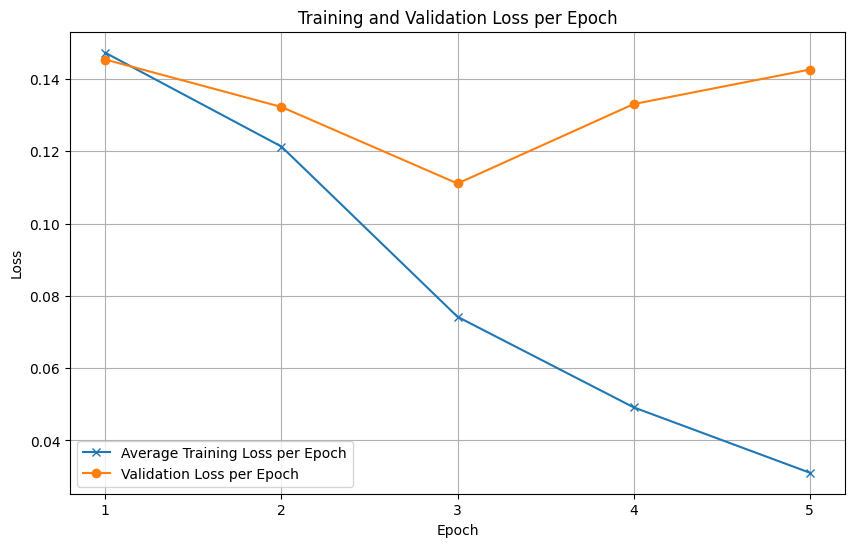

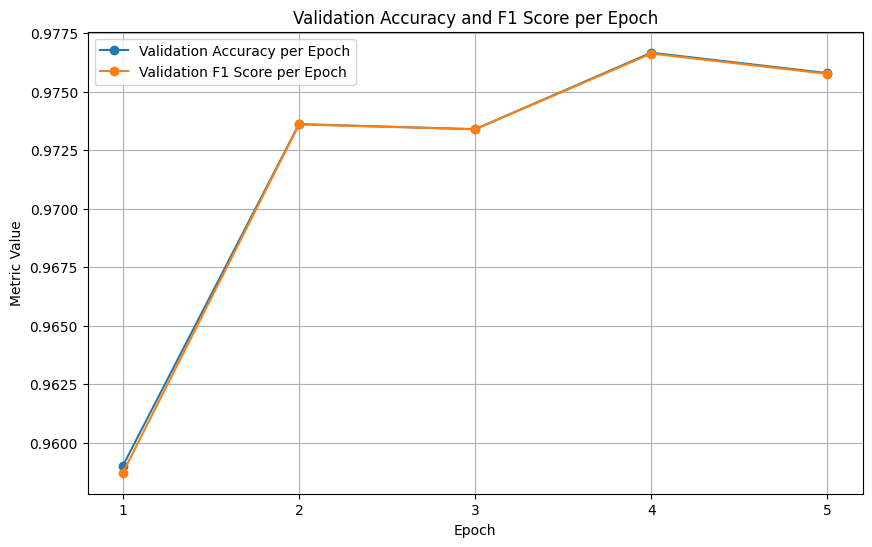

In [34]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import numpy as np

# Define the log directory
LOG_DIR = './logs_a100'

# Function to extract scalar data with step and wall_time
def extract_scalar_data(event_file_path, tag):
    data = []
    try:
        for event in tf.compat.v1.train.summary_iterator(event_file_path):
            if event.summary:
                for value in event.summary.value:
                    if value.tag == tag:
                        data.append({'step': event.step, 'value': value.simple_value})
    except Exception as e:
        print(f"Error reading {event_file_path}: {e}")
    return data

# Iterate through all event files
event_files = [os.path.join(LOG_DIR, f) for f in os.listdir(LOG_DIR) if f.startswith('events.out.tfevents')]

# Initialize lists to store data
all_train_loss_data = []
all_eval_loss_data = []
all_eval_accuracy_data = []
all_eval_f1_data = []

# Define the tags
train_loss_tag = 'train/loss'
eval_loss_tag = 'eval/loss'
eval_accuracy_tag = 'eval/accuracy'
eval_f1_tag = 'eval/f1' # Or 'eval/f1_weighted' if you used weighted F1

for event_file in event_files:
    all_train_loss_data.extend(extract_scalar_data(event_file, train_loss_tag))
    all_eval_loss_data.extend(extract_scalar_data(event_file, eval_loss_tag))
    all_eval_accuracy_data.extend(extract_scalar_data(event_file, eval_accuracy_tag))
    all_eval_f1_data.extend(extract_scalar_data(event_file, eval_f1_tag))


# Sort data by step
all_train_loss_data.sort(key=lambda x: x['step'])
all_eval_loss_data.sort(key=lambda x: x['step'])
all_eval_accuracy_data.sort(key=lambda x: x['step'])
all_eval_f1_data.sort(key=lambda x: x['step'])


# --- Process Training Loss per Epoch ---
train_steps = [d['step'] for d in all_train_loss_data]
train_losses_raw = [d['value'] for d in all_train_loss_data]
eval_steps_for_averaging = [d['step'] for d in all_eval_loss_data] # Use eval loss steps as epoch markers

avg_train_losses_per_epoch = []
train_epochs_for_plot = []

current_train_steps_for_epoch = []
current_epoch = 1
eval_step_index = 0

for i, step in enumerate(train_steps):
    current_train_steps_for_epoch.append(train_losses_raw[i])

    if eval_step_index < len(eval_steps_for_averaging) and step >= eval_steps_for_averaging[eval_step_index]:
        if current_train_steps_for_epoch:
            avg_train_losses_per_epoch.append(np.mean(current_train_steps_for_epoch))
            train_epochs_for_plot.append(current_epoch)
            current_train_steps_for_epoch = []
            current_epoch += 1
        eval_step_index += 1

if current_train_steps_for_epoch:
     if current_epoch <= 5:
        avg_train_losses_per_epoch.append(np.mean(current_train_steps_for_epoch))
        train_epochs_for_plot.append(current_epoch)


# --- Prepare Evaluation Metrics per Epoch ---
# Assuming eval logs happen at the end of each epoch, and potentially at the start/end of training.
# We want to select only the 5 evaluation logs corresponding to the end of each epoch.
# If there are 6 logs, the first is likely initial eval, and the last is likely final eval.

# Assuming the first log is initial eval and the last is final eval, and the middle 5 are epoch-end evals
if len(all_eval_loss_data) > 5:
    eval_losses = [d['value'] for d in all_eval_loss_data][1:6] # Take values from index 1 to 5
    eval_accuracies = [d['value'] for d in all_eval_accuracy_data][1:6]
    eval_f1_scores = [d['value'] for d in all_eval_f1_data][1:6]
else:
    # If there are exactly 5 or fewer, use all available eval data
    eval_losses = [d['value'] for d in all_eval_loss_data]
    eval_accuracies = [d['value'] for d in all_eval_accuracy_data]
    eval_f1_scores = [d['value'] for d in all_eval_f1_data]

eval_epochs = list(range(1, len(eval_losses) + 1)) # Create epoch numbers based on the number of selected eval points

# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(train_epochs_for_plot, avg_train_losses_per_epoch, label='Average Training Loss per Epoch', marker='x')
plt.plot(eval_epochs, eval_losses, label='Validation Loss per Epoch', marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xticks(range(1, 6))
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy and F1 Score
plt.figure(figsize=(10, 6))
plt.plot(eval_epochs, eval_accuracies, label='Validation Accuracy per Epoch', marker='o', linestyle='-')
plt.plot(eval_epochs, eval_f1_scores, label='Validation F1 Score per Epoch', marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Validation Accuracy and F1 Score per Epoch')
plt.xticks(range(1, 6))
plt.legend()
plt.grid(True)
plt.show()

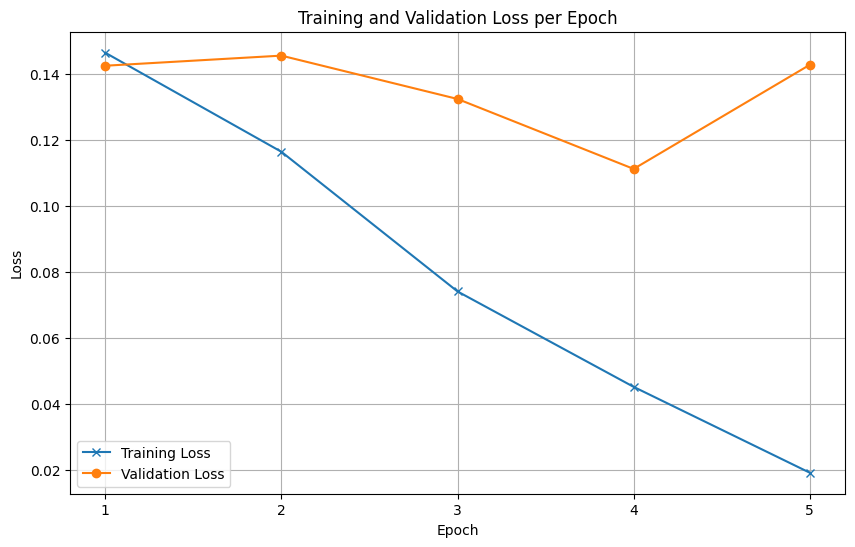

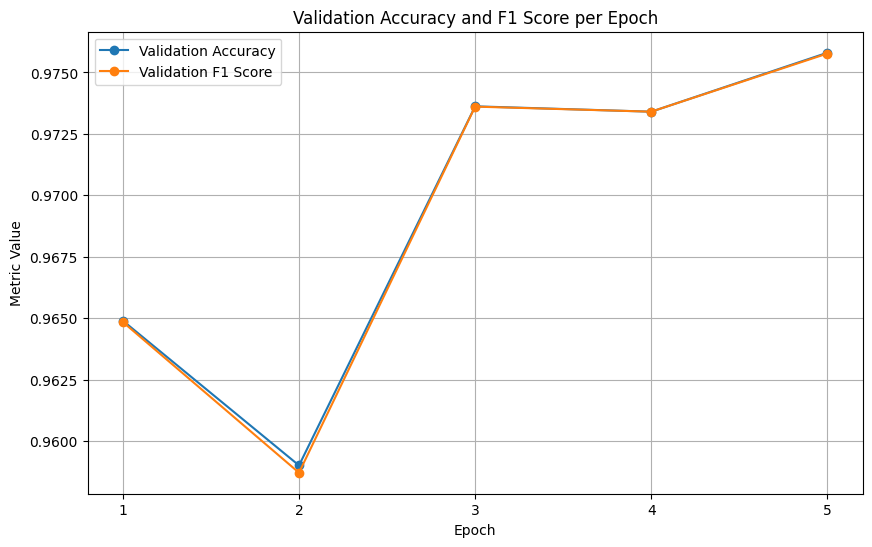

In [35]:
import matplotlib.pyplot as plt

# Data from your training output
epochs = [1, 2, 3, 4, 5]
training_loss = [0.146300, 0.116300, 0.074000, 0.045100, 0.019100]
validation_loss = [0.142361, 0.145421, 0.132294, 0.111111, 0.142639]
accuracy = [0.964901, 0.959015, 0.973621, 0.973403, 0.975801]
f1 = [0.964847, 0.958719, 0.973609, 0.973403, 0.975769]
# Precision and Recall are also available, but let's focus on the ones you asked for in the plot

# --- Plotting ---

# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss', marker='x')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xticks(epochs) # Set x-axis ticks to match epochs
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy and F1 Score
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, label='Validation Accuracy', marker='o', linestyle='-')
plt.plot(epochs, f1, label='Validation F1 Score', marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Validation Accuracy and F1 Score per Epoch')
plt.xticks(epochs) # Set x-axis ticks to match epochs
plt.legend()
plt.grid(True)
plt.show()